In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append("..")

In [3]:
import theano
theano.config.floatX = 'float32'

Couldn't import dot_parser, loading of dot files will not be possible.


In [4]:
import os
import pandas as pd
from sklearn.externals import joblib
import random
from retina.retina_theano import Retina
import numpy as np

In [5]:
from random import sample
def sample_events(folder,n_events):
    fpaths = map(lambda line:os.path.join(folder,line) , os.listdir(folder))
    fpaths = sample(fpaths,n_events)
    events=[]
    for i in range(len(fpaths)):
        fpath = fpaths[i]

        hits = pd.DataFrame.from_csv(fpath)[["X","Y","Z"]].values
        
        if i%100 ==0:
            print i,'/',len(fpaths)
        if len(hits)==0:
            continue
        events.append(hits)
    return events

In [6]:
def spawn_retina():
    ks = np.zeros(3)
    #ks[2]+=1
    ks[0] = np.random.normal(0,1000)
    ks[1] = np.random.normal(0,1000)
    ks[2] = np.random.uniform(-100,15000)
    
    z_c = np.random.uniform(ks[2]-3000,ks[2]+3000)
    alpha = np.arctan(-ks[0]/(z_c-ks[2]))
    beta = np.arctan(-ks[1]/(z_c-ks[2]))
    
    xdim=ydim=32
    dalpha = np.pi/3
    dbeta = np.pi/3
    alphas = np.linspace(-dalpha+alpha, alpha+dalpha,num=xdim)
    bethas = np.linspace(-dbeta+beta, beta+dbeta,num=ydim)
    
    variance = random.choice([10,50,75,100,500])
    
    retina = Retina(ks,alphas,bethas,variance=variance)
    params = ', '.join(map(str,[ks[0],ks[1],ks[2],alpha,beta,variance,
                                xdim,ydim,dalpha,dbeta]))
    return retina,params


In [8]:
def get_retina_response(hits_several,retina):
    responses = []
    for hits in hits_several:
        response = retina.response(hits,block_size=None,
                    n_jobs=1,inner_block_size=None)
        responses.append(response)
    return responses

def retinize(hits_several,retina,n_closest = 3000,n_shards=32):
    nearest_hits_several = []
    for hits in hits_several:
        
        hits_dist = np.linalg.norm(hits-retina.ks,axis=-1)
        
        hits = hits[np.argsort(hits_dist)[:n_closest],:]
        nearest_hits_several.append(hits)
    
    responses=[]
    shard_size = (len(hits_several)-1)/n_shards +1
    
    for shard_i in range(n_shards):
        responses.append(joblib.delayed(get_retina_response)(
                nearest_hits_several[shard_i*shard_size:(shard_i+1)*shard_size],
                retina))
    
        
    responses = [resp for batch in joblib.Parallel(n_jobs = -1)(responses)
                             for resp in batch]
    retina_pts = np.vstack(responses)
    return retina_pts


In [9]:
dir_sig = "/mnt/KSfinder/mc_sig_hits/"
dir_bg  = "/mnt/KSfinder/mc_bg_down_hits/"

In [10]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score

In [ ]:


while True:
    retina,param_str = spawn_retina()
    df_sig =sample_events(dir_sig,50)
    df_bg =sample_events(dir_bg,50)
    evts = df_sig +df_bg
    y = np.zeros(len(evts))
    y[:len(df_sig)]=1
    X = retinize(evts,retina)

    Xtr,Xts,Ytr,Yts = train_test_split(X,y,test_size=0.25)

    model =LogisticRegressionCV().fit(Xtr,Ytr)
    auc_tr = roc_auc_score(Ytr,model.predict_proba(Xtr)[:,1])
    auc_ts = roc_auc_score(Yts,model.predict_proba(Xts)[:,1])
    acc_tr = accuracy_score(Ytr,model.predict(Xtr))
    acc_ts = accuracy_score(Yts,model.predict(Xts))
    res = ', '.join(map(str,[auc_tr,auc_ts,acc_tr,acc_ts]))
    with open("log_test.txt",'a') as fout:
        fout.write(param_str+",:,"+res+"\n")


In [10]:
df = pd.DataFrame.from_csv("log_32x.txt",sep=',',index_col=None)
df.columns = ["x0","y0","z0","alpha","beta","sigma",
        "xdim","ydim","dalpha","dbeta",
        'sc',"auc_tr","auc_ts","acc_tr","acc_ts"]

<matplotlib.colorbar.Colorbar instance at 0x7fd867f10cb0>

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


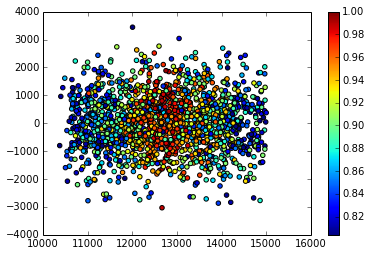

In [11]:
pts = df[df.acc_ts > 0.8]
plt.scatter(pts.z0,pts.y0, c = pts.acc_ts)
plt.colorbar()

In [15]:
df = df.irow(np.argsort(df.acc_ts.values)[::-1])
print df.irow(0),'\n'
print df.irow(1),'\n'
print df.irow(2),'\n'

x0          1016.31
y0          172.755
z0          12969.2
alpha      0.393943
beta      0.0705397
sigma           500
xdim             32
ydim             32
dalpha       1.0472
dbeta        1.0472
sc                :
auc_tr            1
auc_ts            1
acc_tr            1
acc_ts            1
Name: 6472, dtype: object 

x0         293.451
y0         926.326
z0         12645.4
alpha    -0.459309
beta      -1.00112
sigma           50
xdim            32
ydim            32
dalpha      1.0472
dbeta       1.0472
sc               :
auc_tr           1
auc_ts           1
acc_tr           1
acc_ts       0.996
Name: 8016, dtype: object 

x0        -387.769
y0         149.059
z0         13072.7
alpha    -0.296658
beta      0.116967
sigma          500
xdim            32
ydim            32
dalpha      1.0472
dbeta       1.0472
sc               :
auc_tr           1
auc_ts           1
acc_tr           1
acc_ts       0.996
Name: 1956, dtype: object 



/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


<matplotlib.colorbar.Colorbar instance at 0x7f0f84122638>

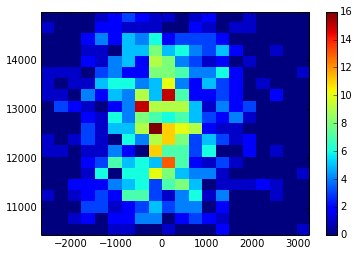

In [12]:
pts = df[df.auc_ts > 0.9]
_= plt.hist2d(pts.y0,pts.z0,bins=[20,20])
plt.colorbar()

In [15]:
import plotly.plotly as py
import plotly.graph_objs as go
from matplotlib import pyplot as plt
%matplotlib inline

In [18]:
def makeline(x,y,z,color='#1f77b4',name="line"):
    return go.Scatter3d(
        x = x,
        y = y,
        z = z,
        mode='lines',
        name=name,
        line=go.Line(
            color=color,
            width=3
        )
    )
layout = go.Layout(
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=65
    ),
    xaxis= {"autorange":False},
    yaxis= {"autorange":False},
    #zaxis= {"autorange":False},
)
axes = makeline([0,1,0,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0,],[0,0,0,0,0,0,0,1,0,],color="red",name="axes")

In [16]:
py.sign_in("justHeuristic","pyqm0lrrrw")

In [19]:

data = [axes]
pts = df[df.acc_ts < 0.6]
data.append(go.Scatter3d(x=pts.alpha,y=pts.beta,z=pts.z0,mode="markers",marker={"color":"grey","size" : 1}))

pts = df[np.logical_and(df.acc_ts >= 0.6,df.acc_ts < 0.8)]
data.append(go.Scatter3d(x=pts.alpha,y=pts.beta,z=pts.z0,mode="markers",marker={"color":"green","size" : 1}))

pts = df[np.logical_and(df.acc_ts >= 0.8,df.acc_ts < 0.9)]
data.append(go.Scatter3d(x=pts.alpha,y=pts.beta,z=pts.z0,mode="markers",marker={"color":"yellow","size" : 1}))

pts = df[df.acc_ts >= 0.9]
data.append(go.Scatter3d(x=pts.alpha,y=pts.beta,z=pts.z0,mode="markers",marker={"color":"red","size" : 1}))

fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

In [145]:
pts = df[df.acc_ts > 0.9]
print len(pts)
from sklearn.cluster import KMeans
xcols = [u'x0', u'y0', u'z0', u'alpha', u'beta', u'sigma', u'pow', u'xdim',
       u'ydim', u'dalpha', u'dbeta']
model = KMeans(n_clusters= 32).fit(pts[xcols])
clusters = pd.DataFrame(model.cluster_centers_,columns=xcols)

168


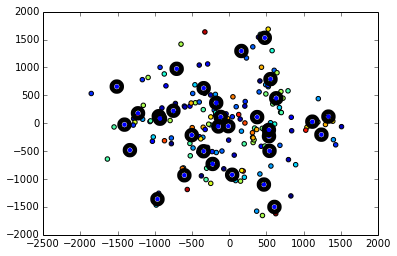

In [147]:
plt.scatter(pts.x0,pts.y0,c= pts.acc_ts)

plt.scatter(clusters.x0,clusters.y0,marker='o',linewidths = 10)

In [149]:

data = [axes]
data.append(go.Scatter3d(x=pts.x0,y=pts.y0,z=pts.z0,mode="markers",marker={"color":"grey","size" : 1}))
data.append(go.Scatter3d(x=clusters.x0,y=clusters.y0,z=clusters.z0,mode="markers",marker={"color":"blue","size" : 5}))

fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

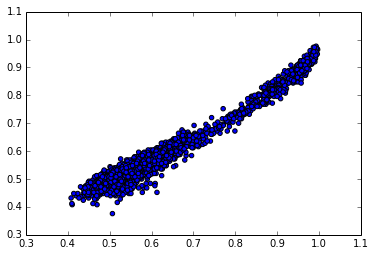

In [59]:
plt.scatter(df.auc_ts,df.acc_ts)

In [153]:
df.irow(904)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning:

irow(i) is deprecated. Please use .iloc[i]



x0         625.645
y0        -1621.71
z0           10745
alpha    -0.319414
beta      0.708715
sigma           50
pow              2
xdim            50
ydim            50
dalpha      1.0472
dbeta       1.0472
sc               :
auc_tr           1
auc_ts    0.993333
acc_tr           1
acc_ts       0.976
Name: 904, dtype: object

In [12]:

xyz1 = pd.DataFrame.from_csv(fd1,)[["X","Y","Z"]].values
fd2 = "../eventtracer/mc_bg_hits/"
xyz2 = pd.DataFrame.from_csv(fd2,)[["X","Y","Z"]].values

def _response(dx,dy,dz


    n_pts = 1000
    xyz1_hits = xyz1[xyz1[:,2]>=ks[2]]
    xyz1_hits = xyz1_hits[np.argsort(xyz1_hits[:,2])[:n_pts]]

    xyz2_hits = xyz2[xyz2[:,2]>=ks[2]]
    xyz2_hits = xyz2_hits[np.argsort(xyz2_hits[:,2])[:n_pts]]
    
    
    
    nthreads = 1
    
    img1 = retina.response(xyz1_hits,block_size = (len(xyz1)-1)/nthreads+1,n_jobs=nthreads)
    img2 = retina.response(xyz2_hits,block_size = (len(xyz2)-1)/nthreads+1,n_jobs=nthreads)
    return ks[2],img1,img2

tasks = map(joblib.delayed(_response),range(150))
frames = joblib.Parallel(n_jobs=-1)(tasks)

In [1]:
from IPython import display
for z,img1,img2 in frames:
    xdim=ydim=32
    
    
    plt.figure(figsize=[14,8])
    _p0 = plt.subplot(1,2,0)
    _im0 = _p0.imshow(img1.reshape(xdim,ydim),vmin=0,vmax=7,interpolation='nearest',cmap="hot")
    _p1 = plt.subplot(1,2,1)
    _im1 = _p1.imshow(img2.reshape(xdim,ydim),vmin=0,vmax=7,interpolation='nearest',cmap="hot")
    

    plt.colorbar(_im0,ax=_p0)
    plt.colorbar(_im1,ax=_p1)
    plt.show()
    #print z
    display.clear_output(wait=True)


NameError: name 'frames' is not defined